In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


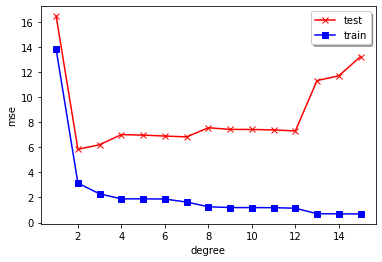

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


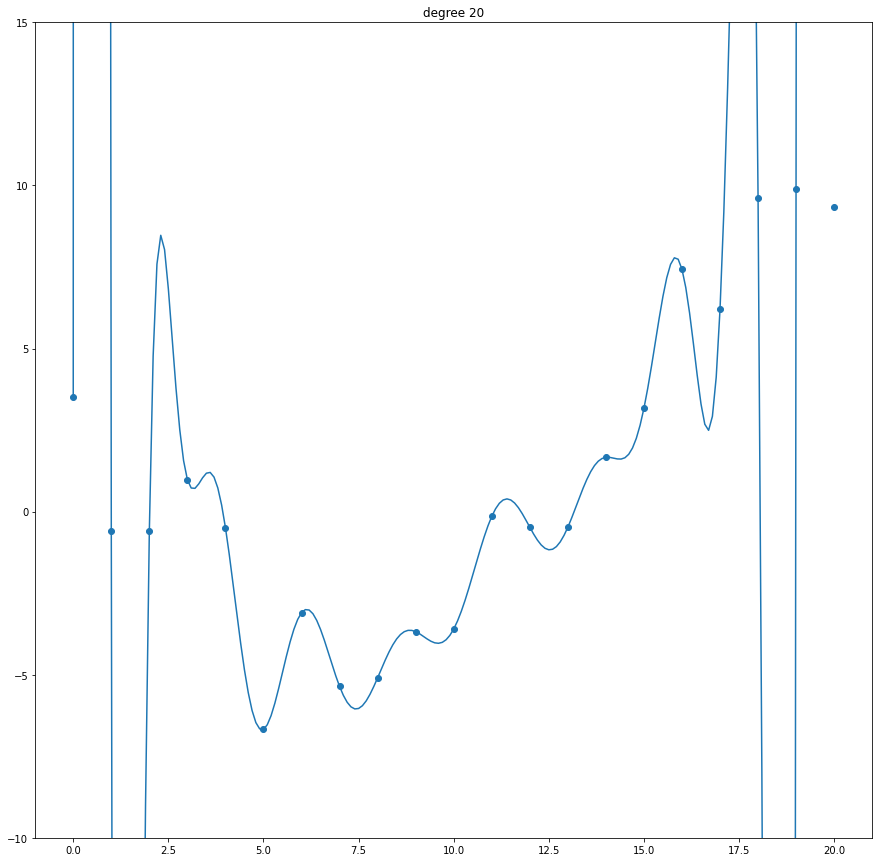

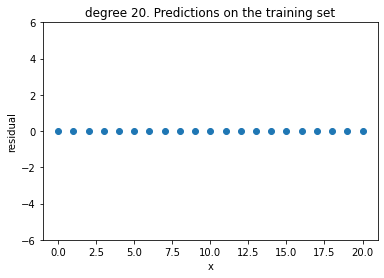

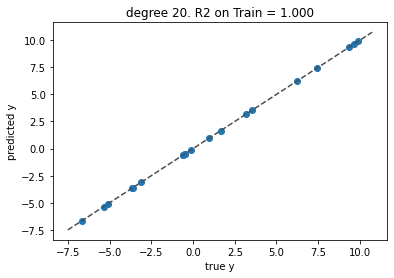

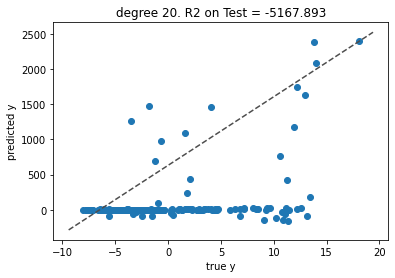

In [4]:
# Plot polynomial regression on 1d problem
# Based on https://github.com/probml/pmtk3/blob/master/demos/linregPolyVsDegree.m


import numpy as np
import matplotlib.pyplot as plt
import os
images_dir = '/content/drive/MyDrive/AdvancedML/Homework1/Fig1.7/'

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    from sklearn.preprocessing import PolynomialFeatures
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from sklearn.metrics import mean_squared_error as mse


def make_1dregression_data(n=21):
    np.random.seed(0)
    xtrain = np.linspace(0.0, 20, n)
    xtest = np.arange(0.0, 20, 0.1)
    sigma2 = 4
    w = np.array([-1.5, 1 / 9.0])
    fun = lambda x: w[0] * x + w[1] * np.square(x)
    ytrain = fun(xtrain) + np.random.normal(0, 1, xtrain.shape) * np.sqrt(sigma2)
    ytest = fun(xtest) + np.random.normal(0, 1, xtest.shape) * np.sqrt(sigma2)
    return xtrain, ytrain, xtest, ytest


xtrain, ytrain, xtest, ytest = make_1dregression_data(n=21)

# Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))


degs = np.arange(1, 21, 1)
ndegs = np.max(degs)
mse_train = np.empty(ndegs)
mse_test = np.empty(ndegs)
ytest_pred_stored = np.empty(ndegs, dtype=np.ndarray)
ytrain_pred_stored = np.empty(ndegs, dtype=np.ndarray)
for deg in degs:
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain)
    ytrain_pred = model.predict(Xtrain_poly)
    ytrain_pred_stored[deg - 1] = ytrain_pred
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[deg - 1] = mse(ytrain_pred, ytrain)
    mse_test[deg - 1] = mse(ytest_pred, ytest)
    ytest_pred_stored[deg - 1] = ytest_pred

# Plot MSE vs degree
fig, ax = plt.subplots()
mask = degs <= 15
ax.plot(degs[mask], mse_test[mask], color="r", marker="x", label="test")
ax.plot(degs[mask], mse_train[mask], color="b", marker="s", label="train")
ax.legend(loc="upper right", shadow=True)
plt.xlabel("degree")
plt.ylabel("mse")
plt.savefig(f"{images_dir}/polyfitVsDegree.png")
plt.show()

# Plot fitted functions
chosen_degs = [1, 2, 3, 14, 20]
chosen_degs = [20]
for deg in chosen_degs:
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(xtrain, ytrain)
    ax.plot(xtest, ytest_pred_stored[deg - 1])
    ax.set_ylim((-10, 15))
    plt.title("degree {}".format(deg))
    pml.savefig("{}polyfitDegree{}.png".format(images_dir, deg))
    plt.show()

# Plot residuals
for deg in chosen_degs:
    fig, ax = plt.subplots()
    ypred = ytrain_pred_stored[deg - 1]
    residuals = ytrain - ypred
    # ax.plot(ypred, residuals, 'o')
    # ax.set_xlabel('predicted y')
    ax.plot(xtrain, residuals, "o")
    ax.set_xlabel("x")
    ax.set_ylabel("residual")
    ax.set_ylim(-6, 6)
    plt.title("degree {}. Predictions on the training set".format(deg))
    plt.savefig("{}polyfitDegree{}Residuals.png".format(images_dir, deg))
    plt.show()

# Plot fit vs actual
for deg in chosen_degs:
    for train in [True, False]:
        if train:
            ytrue = ytrain
            ypred = ytrain_pred_stored[deg - 1]
            dataset = "Train"
        else:
            ytrue = ytest
            ypred = ytest_pred_stored[deg - 1]
            dataset = "Test"
        fig, ax = plt.subplots()
        ax.scatter(ytrue, ypred)
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        ax.set_xlabel("true y")
        ax.set_ylabel("predicted y")
        r2 = sklearn.metrics.r2_score(ytrue, ypred)
        plt.title("degree {}. R2 on {} = {:0.3f}".format(deg, dataset, r2))
        plt.savefig("{}polyfitDegree{}FitVsActual{}.png".format(images_dir, deg, dataset))
        plt.show()